In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json
import h5py
from scipy import signal
from scipy.optimize import curve_fit

In [2]:
def mygauss(x,mu,sigma,amp):
    f=amp*np.exp(-0.5*(x-mu)**2/sigma**2)
    return f

In [3]:
def smooth(data,sigma=5):
    dataft=np.fft.rfft(data)
    x=np.fft.fftfreq(len(data))*len(data)
    gauss=np.exp(-0.5*(x**2)/sigma**2)
    gauss=gauss/gauss.sum()
    kernelft=np.fft.rfft(gauss)
    res=np.fft.irfft(dataft*kernelft)
    return res

In [4]:
def read_template(filename):
    dataFile=h5py.File(filename,'r')
    template=dataFile['template']
    th=template[0]
    tl=template[1]
    return th,tl
def read_raw(filename):
    dataFile=h5py.File(filename,'r')
    dqInfo = dataFile['quality']['simple']
    qmask=dqInfo['DQmask'][...]

    meta=dataFile['meta']
    #gpsStart=meta['GPSstart'].value
    gpsStart=meta['GPSstart'][()]
    #print meta.keys()
    #utc=meta['UTCstart'].value
    utc=meta['UTCstart'][()]
    #duration=meta['Duration'].value
    duration=meta['Duration'][()]
    #strain=dataFile['strain']['Strain'].value
    strain=dataFile['strain']['Strain'][()]
    dt=(1.0*duration)/len(strain)
    
    dataFile.close()
    return strain,dt,utc

In [5]:


def get_xcorr(strain,template,window,noise_ps):
    N=len(strain)
    dataft = np.fft.fft(strain*window)
    # whitening is only useful for visualization in this case
    dataft_white = dataft/np.sqrt(noise_ps)
    tempft = np.fft.fft(template*window)
    tempft_white = tempft/np.sqrt(noise_ps)
    
    weights = np.abs(tempft_white[:N//2])
    wt_sum = weights.sum()
    idhalf = np.argmin(np.abs(weights.cumsum()-wt_sum/2))
    print("Half the weight is contributed by frequencies upto:", idhalf*4096/N, "Hz")

    lhs = np.sum(template*N*np.fft.ifft(tempft/noise_ps))
    rhs = np.fft.ifft(tempft_white*N*np.conj(dataft_white))
    xcorr=np.abs(rhs)/np.abs(lhs)
    return rhs,lhs
    

In [6]:
rootdir = './LOSC_Event_tutorial-master/'
with open(rootdir+"BBH_events_v3.json", "r") as read_file:
    events = json.load(read_file)

In [7]:
eventnames = list(events.keys())

### NOISE ESTIMATION (duplicate)

In [8]:
han_ps = []
liv_ps = []
# sos = signal.butter(6, 0.9, 'low',output='sos')

for event in eventnames:
    fname=events[event]['fn_H1']
    strain,dt,utc = read_raw(rootdir+fname)
    N=len(strain)
    
    win=signal.windows.tukey(N)
#     strain_filt=signal.sosfilt(sos,strain*win)
    dataft = np.fft.fft(win*strain)
#     dataft = np.fft.fft(strain_filt)
    ps=np.abs(dataft)**2
    han_ps.append(ps)
    
    fname=events[event]['fn_L1']
    strain,dt,utc = read_raw(rootdir+fname)
    N=len(strain)
    win=signal.windows.tukey(N)
    dataft = np.fft.fft(win*strain)
#     strain_filt=signal.sosfilt(sos,strain*win)
#     dataft = np.fft.fft(win*strain_filt)
    ps=np.abs(dataft)**2
    liv_ps.append(ps)

han_ps = np.mean(np.asarray(han_ps),axis=0).ravel()
liv_ps = np.mean(np.asarray(liv_ps),axis=0).ravel()

Text(0.5, 1.0, 'Livingston Noise')

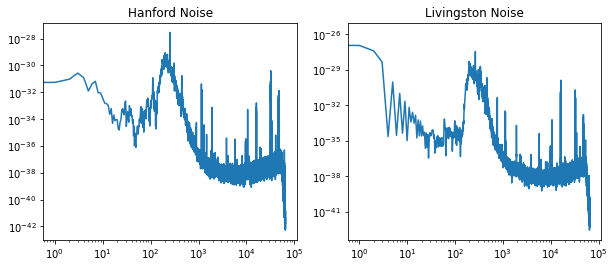

In [9]:
f=plt.gcf()
f.set_size_inches(10,4)
plt.subplot(121)
plt.loglog(han_ps[:N//2])
plt.title('Hanford Noise')

plt.subplot(122)
plt.loglog(liv_ps[:N//2])
plt.title('Livingston Noise')

In [10]:
han_ps_smooth = smooth(han_ps,6)
liv_ps_smooth = smooth(liv_ps,6)

Text(0.5, 1.0, 'Livingston Noise')

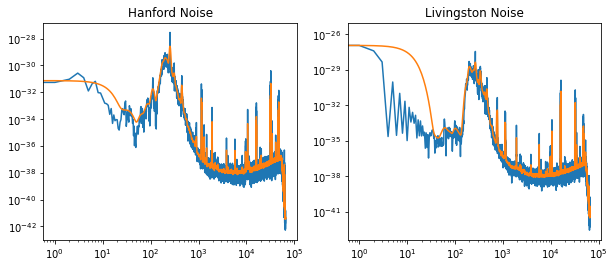

In [11]:
f=plt.gcf()
f.set_size_inches(10,4)
plt.subplot(121)
plt.loglog(han_ps[:N//2])
plt.loglog(han_ps_smooth[:N//2])
plt.title('Hanford Noise')

plt.subplot(122)
plt.loglog(liv_ps[:N//2])
plt.loglog(liv_ps_smooth[:N//2])
plt.title('Livingston Noise')

### MAIN CODE BEGINS

In [12]:
template_name=events[eventnames[1]]['fn_template']

#Hanford
fname=events[eventnames[1]]['fn_H1']
strain,dt,utc = read_raw(rootdir+fname)
th,tl = read_template(rootdir+template_name)
template = th
rhs,lhs=get_xcorr(strain,template,win,han_ps_smooth)
xcorr_h=np.abs(rhs)/np.abs(lhs)
idmax_h=np.argmax(xcorr_h)
noise1_h = np.sqrt(1/np.abs(lhs)) #analytically expected error bar on amplitude
mynoise_h=np.std(xcorr_h[:40000]) #from scatter in data



#livingston
fname=events[eventnames[1]]['fn_L1']
strain,dt,utc = read_raw(rootdir+fname)
th,tl = read_template(rootdir+template_name)
template = th
rhs,lhs=get_xcorr(strain,template,win,liv_ps_smooth)
xcorr_l=np.abs(rhs)/np.abs(lhs)
idmax_l=np.argmax(xcorr_l)
noise1_l = np.sqrt(1/np.abs(lhs)) #analytically expected error bar on amplitude
mynoise_l=np.std(xcorr_l[:40000]) #from scatter in data

Half the weight is contributed by frequencies upto: 118.875 Hz
Half the weight is contributed by frequencies upto: 132.65625 Hz


(-0.44384765625, -0.439208984375)

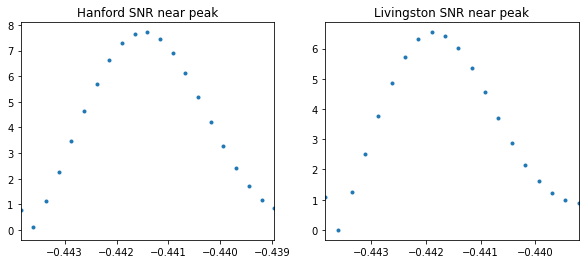

In [13]:
f=plt.gcf()
f.set_size_inches(10,4)
t = np.fft.fftfreq(len(strain))*len(strain)*dt
plt.subplot(121)
snr_h = xcorr_h/noise1_h
plt.plot(t,snr_h,'.')
plt.title('Hanford SNR near peak')
plt.xlim(t[idmax_h-10],t[idmax_h+10])

plt.subplot(122)
snr_l = xcorr_l/noise1_l
plt.plot(t,snr_l,'.')
plt.title('Livingston SNR near peak')
plt.xlim(t[idmax_l-8],t[idmax_l+11])

In [14]:
fitp_h,cov_h=curve_fit(mygauss,t[idmax_h-10:idmax_h+10],snr_h[idmax_h-10:idmax_h+10],p0=[t[idmax_h],0.002,snr_h[idmax_h]])
fitp_l,cov_l=curve_fit(mygauss,t[idmax_l-10:idmax_l+8],snr_l[idmax_l-10:idmax_l+8],p0=[t[idmax_l],0.002,snr_l[idmax_l]])

In [15]:
print(fitp_h,fitp_l)

[-4.41427481e-01  1.09408604e-03  7.88151113e+00] [-4.41771921e-01  1.03729650e-03  6.51602259e+00]


In [16]:
print(f"HANFORD ampl: {np.max(xcorr_h):4.2e} ")
print(f"analy   noise: {noise1_h:4.2e}  analy   SNR: {np.max(xcorr_h)/noise1_h:4.2f}")
print(f"scatter noise: {mynoise_h:4.2e}  scatter SNR: {np.max(xcorr_h)/mynoise_h:4.2f}")
print(f"LIVINGS ampl: {np.max(xcorr_l):4.2e} ")
print(f"analy   noise: {noise1_l:4.2e}  analy   SNR: {np.max(xcorr_l)/noise1_l:4.2f}")
print(f"scatter noise: {mynoise_l:4.2e}  scatter SNR: {np.max(xcorr_l)/mynoise_l:4.2f}")

print(f"\nCombined analy SNR: {np.sqrt(snr_h[idmax_h]**2+snr_l[idmax_l]**2):4.2f}")

HANFORD ampl: 6.72e-04 
analy   noise: 8.71e-05  analy   SNR: 7.71
scatter noise: 5.99e-05  scatter SNR: 11.21
LIVINGS ampl: 6.38e-04 
analy   noise: 9.75e-05  analy   SNR: 6.54
scatter noise: 6.62e-05  scatter SNR: 9.63

Combined analy SNR: 10.12


In [17]:
timediff = (idmax_h - idmax_l)*dt # time delay between the two stations
delay_sigma = np.sqrt(fitp_h[1]**2 + fitp_l[1]**2)
print(f"Time delay b/w 2 stations is {timediff:5.2e} s, and error on it is: {delay_sigma:5.2e} s")

Time delay b/w 2 stations is 4.88e-04 s, and error on it is: 1.51e-03 s


### POSITION ERROR and LOCALIZATION MAP

In [18]:
c=3e8 #m/s
d=3e6 # m
pos_error = c * np.abs(delay_sigma)/d / np.sqrt(1 - (c*np.abs(timediff)/d)**2)

print(f"Error in position is {pos_error*180/np.pi:4.2f} degrees")

Error in position is 8.65 degrees


In [19]:
import healpy as hp

In [20]:
coor_liv = np.deg2rad(np.asarray([30+(33/60)+(46.42/3600), -(90+46/60+27.27/3600)]))
coor_han = np.deg2rad(np.asarray([46+27/60+18.52/3600, -(119+24/60+27.56/3600)]))

han = np.asarray([np.cos(coor_han[0])*np.cos(coor_han[1]), np.cos(coor_han[0])*np.sin(coor_han[1]), np.sin(coor_han[0])])
liv = np.asarray([np.cos(coor_liv[0])*np.cos(coor_liv[1]), np.cos(coor_liv[0])*np.sin(coor_liv[1]), np.sin(coor_liv[0])])

In [21]:
nside=256
pix_th,pix_phi = hp.pix2ang(nside,np.arange(hp.nside2npix(nside)))

In [22]:
b = (han-liv)*6378000 #m
# b = (liv-han)*6378000

In [23]:
np.sqrt(b@b)

3001988.684633395

In [24]:
prob = np.zeros(hp.nside2npix(nside))

In [25]:
for i in range(hp.nside2npix(nside)):
    th,phi=pix_th[i],pix_phi[i]
    n = np.asarray([np.sin(th)*np.cos(phi), np.sin(th)*np.sin(phi), np.cos(th)])
    delay = b@n/3e8
    prob[i] = np.exp(-0.5*(delay-timediff)**2/delay_sigma**2)
    

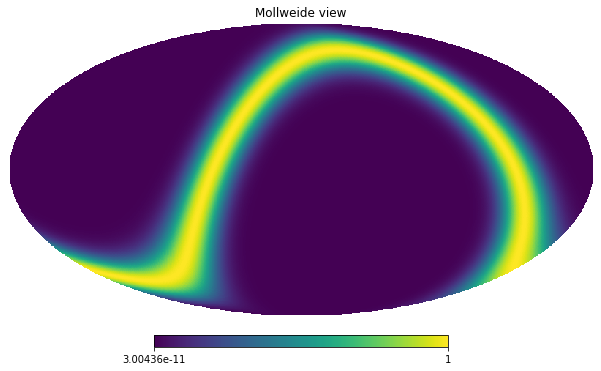

In [26]:
hp.mollview(prob)